### Importing Libraries and mounting drive

In [1]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=07021647a71b88bb335c110cb1ae9d749cc417a2dee56d8599cf74ee35d57fe9
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# import face_recognition
import random
import cv2
# import torch
import pywt

# from torch.utils.data import DataLoader

from skimage.filters import gabor_kernel

import dlib
from scipy import ndimage as ndi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

### All Functions

In [6]:
def find_biggest_BLOb(BLObs):
    areas = []
    for face in BLObs:
        x1 = face.left() # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        areas.append(w * h)    
    return areas.index(max(areas))


In [7]:
def get_face(faces, image):
    if len(faces) > 0:
        face_index = find_biggest_BLOb(faces)
        face = faces[face_index]
    
        x1 = abs(face.left()) # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        face_crop = image[y1:y1 + h, x1:x1 + w]
    else:
        face_crop = None
        face = None
    return face_crop, face

In [8]:
def crop_img (image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat")
    
    faces = detector(image)
            
    [face_crop, face] = get_face(faces, image)
        
    if face != None:
        isLandmarkWorking = True
        landmarks = predictor(image=image, box=face)
    else:
        isLandmarkWorking = False
        face_crop = face_recognition.face_locations(image)
        if len(face_crop) > 0:
            x, y, w, h = face_crop[0]
            if h == 0:
                h = 92
            face_crop = image[y:y + h, x:x + w]
        else:
            face_crop = image

    return [face_crop]

In [9]:
def summer(decomposition):
    keys = ['face']
    HAAR_features = []
    for key in keys:
        cA, (cH, cV, cD) = decomposition[key]
        HAAR_features.append(round(np.sum(cA),1))
        HAAR_features.append(round(np.sum(cH),1))
#         HAAR_features.append(round(np.sum(cV),1))
        HAAR_features.append(round(np.sum(cD),1))
#         HAAR_features.append(np.sum(cA),np.sum(cH),np.sum(cV),np.sum(cD))
    return HAAR_features

In [10]:
def HAAR_filter(face):
    decompositions = {'face':[]}
    try:
      decompositions['face'] = pywt.dwt2(face,'haar','constant')
    except:
      decompositions['face'] = 1,(1,1,1)
    # decompositions['face'] = pywt.dwt2(face,'haar','constant')
    return decompositions

In [11]:
def Gabor_filter():
    kernels = []
    angles = [0,22.5,45,67.5,90,112.5,135, 157.5, 180] #determines what orientation kernels respond to
    frequencies = [0.2,0.3,0.4] #determines sensitivity to gradients (lines)

    for theta in angles:
        for frequency in frequencies:
            kernel = np.real(gabor_kernel(frequency, theta=theta))
            kernels.append(kernel)
                             
    return kernels

In [12]:
def compute_Gabor_features(face, kernels):
    features = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(face, kernel, mode='wrap')
        features.append((np.sum(filtered)))
    
    return features

In [13]:
def create_haar_features(folder_path, target): 
    column_names = [str(x) for x in range(31)]
    df = pd.DataFrame(columns=column_names)


    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.jpg'):
                source_file = os.path.join(dirpath, filename)
                image = cv2.imread(source_file, cv2.IMREAD_GRAYSCALE)
                
                [face] = crop_img(image)
          
            
                decompositions = HAAR_filter(face)
                HAAR_features = summer(decompositions)


                features = HAAR_features
    
                
                kernels = Gabor_filter()
                Gabor_features = compute_Gabor_features(face, kernels)
                [features.append(feat) for feat in Gabor_features]
                features = np.append(features,target)

                
                df.loc[len(df), :] = features
                
                
    return [df]

In [14]:
def face_as_df(folder_path, target):
    column_names = [str(x) for x in range(3601)]
    df = pd.DataFrame(columns=column_names)
    
    counter = 0
    
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.jpg'):
                source_file = os.path.join(dirpath, filename)
                image = cv2.imread(source_file, cv2.IMREAD_GRAYSCALE)
                
                [face] = crop_img(image)

                if len(face) > 0:
                  resized_face = cv2.resize(face, (60, 60))

                else:
                  resized_face = cv2.resize(image, (60, 60))
                
                features = resized_face.flatten()
                
                features = np.append(features,target)
                
                df.loc[len(df), :] = features
                
                
    return [df]

### Accessing data

In [60]:
def get_data(mode):
  if mode == 'scratch':
    !unzip /content/drive/MyDrive/Celeb_evaluation.zip -d /content/drive/MyDrive/
    
    #To get handcrafted features
    test_haar_real = create_haar_features('/content/drive/MyDrive/Celeb_evaluation/real', 'real')
    test_haar_fake = create_haar_features('/content/drive/MyDrive/Celeb_evaluation/fake', 'fake') 
    df_test = pd.concat([test_haar_real, test_haar_fake], axis=0).reset_index(drop=True)

    #To get face image for CNN features
    test_face_real = face_as_df('/content/drive/MyDrive/Celeb_evaluation/real', 'real')
    test_face_fake = face_as_df('/content/drive/MyDrive/Celeb_evaluation/fake', 'fake')
    df_face_test = pd.concat([test_face_real, test_face_fake], axis=0).reset_index(drop=True)

  else:
    df_test = pd.read_csv('/content/drive/MyDrive/celeb_df_unshuffled')
    df_face_test = pd.read_csv('/content/drive/MyDrive/celeb_df_face_unshuffled')
  return [df_test, df_face_test]

In [85]:
mode = 'from_df'
[df_test, df_face_test] = get_data(mode)

### Preprocessing & feature extraction

##### Processing Face Image and resizing for CNN

In [65]:
df_face_test = df_face_test.drop(df_face_test.columns[0],axis=1)
df_face_test['3600'] = df_face_test['3600'].map({'real': 0, 'fake': 1})

In [66]:
face_test_labels = df_face_test['3600']

In [67]:
face_test_labels_one_hot = keras.utils.to_categorical(face_test_labels, 2)

In [68]:
face_test_data = df_face_test.drop(columns=['3600'])

In [69]:
face_x_test = np.array([np.array(face_test_data.loc[x,:]).reshape((60, 60)) for x in range(face_test_data.shape[0])])

##### Processing Handcrafted Feature obtained Haar and Gabor filters

In [87]:
df_test = df_test.drop(df_test.columns[0],axis=1)
df_test['30'] = df_test['30'].map({'real': 0, 'fake': 1})

In [88]:
test_labels = df_test['30']

In [89]:
test_labels_one_hot = keras.utils.to_categorical(test_labels, 2)

In [90]:
test_data = df_test.drop(df_test.columns[-1],axis=1)

### Importing the model

In [44]:
model = keras.models.load_model('/content/drive/MyDrive/task1_model.h5')

### Evaluating model performance by comparing predictions to ground truth

##### Obtaining Groundtruth

In [95]:
def get_ground_truth():
  zeros = np.zeros(300).astype(int).tolist()
  ones = np.ones(300).astype(int).tolist()

  y_true = zeros + ones
  return y_true

In [96]:
y_true = get_ground_truth()

##### Obtaining Predictions

In [97]:
def get_result():
  pred = model.predict([np.asarray(face_x_test).astype('float32'), np.asarray(test_data).astype('float32')])
  result = []
  for i in range(len(pred)):
    if pred[i][0] > pred[i][1]:
      result.append(0)
    else:
      result.append(1)

  return result

In [98]:
y_pred = get_result()

19/19 [==============================] - 1s 39ms/step


##### Confusion Matrix

In [99]:
print(f'Confusion Matrix is: {confusion_matrix(y_true, y_pred)}')

Confusion Matrix is: [[181 119]
 [181 119]]


##### Prediction Accuracy

In [100]:
print(f'Accuracy is: {accuracy_score(y_true, y_pred)}')

Accuracy is: 0.5


##### Plotting Curves

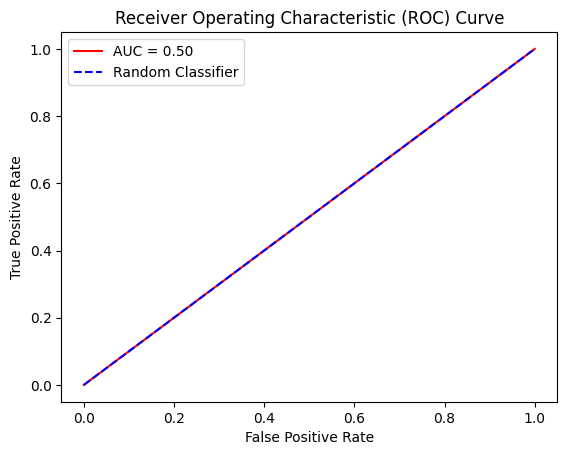

In [101]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}',color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()